In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
from tqdm import tqdm
import sys
sys.path.append("../stabilvol")
from utility.classes.data_extraction import DataExtractor
from utility.classes.stability_analysis import StabilVolter

START_DATE = '1980-01-01'
END_DATE = '2022-07-01'
CRITERION = 'percentage'
VALUE = 0.05
START_LEVEL = -2.0
END_LEVEL = -1.0

START_LEVELS = [0.1, 0.2, 0.5, 1.0, 2.0]
DELTAS = [0.1, 0.2, 0.5, 1.0, 2.0]
LEVELS = {
    (start, start+delta) for start in START_LEVELS for delta in DELTAS
}
TAU_MAX = 30
LOOK_STOCK = "NVR"

In [2]:
filename = '../data/interim/UN.pickle'
accountant = DataExtractor(
        start_date=START_DATE,
        end_date=END_DATE,
        criterion=CRITERION,
        criterion_value=VALUE,
        sigma_range=(1e-5, 1e5)
    )
analyst = StabilVolter(
    start_level=START_LEVEL,
    end_level=END_LEVEL,
    tau_max=TAU_MAX)
df = accountant.extract_data(filename)
print(len(df.columns))
sample_columns = ['NVR', 'HP', 'USA', 'SWX', 'CPAC']
# dfl = df.sample(100, axis='columns')
dfl = df.loc[:, sample_columns]

# print(dfl.iloc[:, :5].columns)

2059


In [3]:
def save_basic_markets_info():
    rows = []
    for market in ["UN", "UW", "LN", "JT"]:
        df = accountant.extract_data(f"../data/interim/{market}.pickle")
        rows.append([
            df.shape[0],
            df.shape[1],
            df.count().max(),
            df.count().min(),
            df.std().mean(),
            df.max().max(),
            df.min().min(),
        ])

    market_data = pd.DataFrame(rows, 
                columns=["Days", "Stocks", "Max Days Traded", "Min Days Traded", "Average Std", "Max", "Min"],
                index=["UN", "UW", "LN", "JT"]).T
    market_data.to_csv('../data/interim/market_returns_data.csv')

# save_basic_markets_info()

In [4]:
total_std = df.std().mean()
start = START_LEVEL * total_std
end = END_LEVEL * total_std
print(total_std, start, end, sep='\n')

0.026236702970754727
-0.052473405941509454
-0.026236702970754727


0.026236702970754727
-0.052473405941509454
-0.026236702970754727


<Axes: >

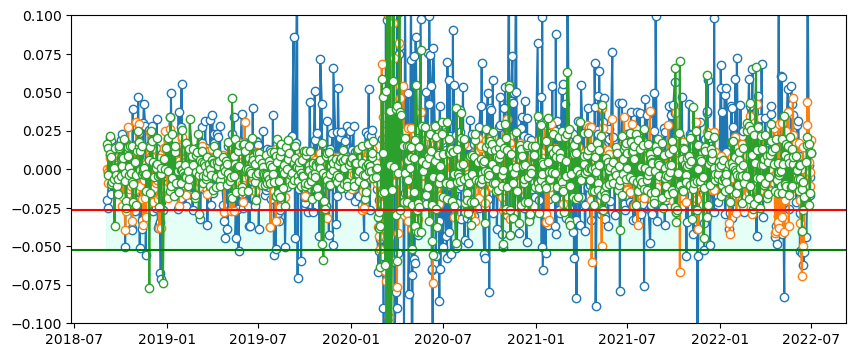

In [5]:
analyst.data = df
print(analyst.total_std)
print(analyst.threshold_start)
print(analyst.threshold_end)
analyst.plot_thresholds(dfl.columns[1:4].values, x_range=(df.index[-1000], df.index[-1]), y_range=(-0.1, 0.1))

In [6]:
def count_stock_fht(
            series, 
            start_level, end_level, divergence_limit,
            tau_min, tau_max, squeeze=True, **kwargs
    ):
        # Make series continuous
        series = series.dropna()
        if end_level > start_level:
            print("Rally")
            series, start_level, end_level = -series, -start_level, -end_level
        counting = False
        counting_time = 0
        fht = []
        volatility = []
        starts = []
        ends = []
        start_t = 0
        reset = True
        start_counting_date = pd.Timestamp('1980-01-01')
        for t, (date, level) in enumerate(series.items()):
            # pbar.set_description_str(f"{t}")
            # pbar.set_postfix_str(f"- {'Counting' if counting else 'idle'}")
            if level > start_level:
                # Start counting
                counting = True
                start_t = t
                start_counting_date = date
            if abs(level) > divergence_limit and counting_time < tau_max:
                # pbar.set_postfix_str('Divergent')
                # Stop counting and pass on
                counting = False
            if counting and level < end_level:
                # pbar.set_postfix_str('Stop')
                # Stop counting and take FHT
                counting = False
                end_t = t
                end_counting_date = date
                counting_time = end_t - start_t
                if tau_min <= counting_time <= tau_max:
                    # Append FHT and Volatility
                    local_volatility = series[start_t: end_t].std(ddof=1)
                    fht.append(counting_time)
                    volatility.append(local_volatility)
                    starts.append(start_counting_date)
                    ends.append(end_counting_date)
        # Gather data in a DataFrame
        stock_stabilvol = np.array([volatility, fht, starts, ends])
        if squeeze:
            stock_stabilvol = stock_stabilvol.flatten()
        return stock_stabilvol

def get_stabilvol(data, *args, method='pandas', **frame_info) -> pd.DataFrame:
    threshold_start, threshold_end, divergence, tau_max, tau_min = args
    print(f"#: {len(data)}, Start: {threshold_start}, End: {threshold_end}, MaxT: {tau_max}, MinT: {tau_min}")

    if method == 'pandas':
        tqdm.pandas()
        result = data.progress_apply(count_stock_fht, args=args, squeeze=True)
        if result.empty:
            raise ValueError("No results for this choise of parameters.")
        result_matrix = [series.reshape(4, -1) for series in result]
        stabilvol = pd.DataFrame(np.concatenate(result_matrix, axis=1).T, columns=['Volatility', 'FHT', 'start', 'end'])

    return stabilvol
# fht = get_stabilvol(dfl, *args, squeeze=False)

In [7]:
a1 = StabilVolter(
    start_level=-2.0,
    end_level=-1.0,
    tau_max=30)
a2 = StabilVolter(
    start_level=-2.0,
    end_level=0.0,
    tau_max=30)
a3 = StabilVolter(
    start_level=2.0,
    end_level=1.0,
    tau_max=30)
a4 = StabilVolter(
    start_level=2.0,
    end_level=0.0,
    tau_max=30)
a5 = StabilVolter(
    start_level=-1.0,
    end_level=-2.0,
    tau_max=30)
a6 = StabilVolter(
    start_level=1.0,
    end_level=2.0,
    tau_max=30)
fh1 = a1.data = dfl
fh2 = a2.data = dfl
fh2 = a3.data = dfl
fh2 = a4.data = dfl
fh2 = a5.data = dfl
fh2 = a6.data = dfl

In [8]:
def extract_args(a):
    return (
        a.threshold_start,
        a.threshold_end,
        a.divergence_limit,
        a.tau_min,
        a.tau_max,
    )
xrange = ('2022-01-01', '2022-04-01')
# stocks = np.random.choice(dfl.columns, 1)
stocks = [LOOK_STOCK]
print(stocks)

['HP']


Compare the counting algorithm defined here with the method defined in the StabilVolter class

Rally


<Axes: title={'center': 'Thresholds: $1.0\\sigma$ / $2.0\\sigma$'}>

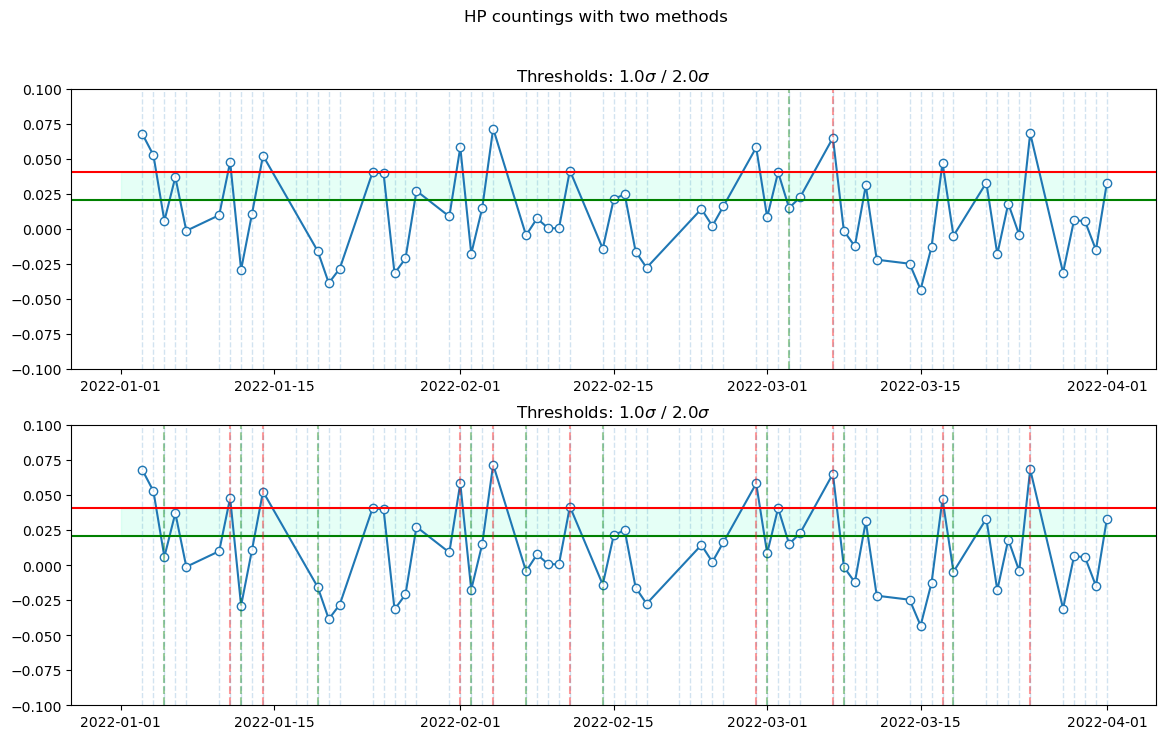

In [10]:
def extract_counting_zones(series, a):
    fht=count_stock_fht(series, *extract_args(a), squeeze=False)
    startings = []
    endings = []
    if len(fht) == 4:
        startings.extend(fht[-2])
        endings.extend(fht[-1])
    else:
        print(f"No results in analyst {a}")
    return startings, endings

def extract_counting_zones_2(series, a):
    args = extract_args(a)[:3]
    fht=a.count_stock_fht(series, *args)
    startings = []
    endings = []
    if len(fht) == 4:
        startings.extend(fht[-2])
        endings.extend(fht[-1])
    else:
        print(f"No results in analyst {a}")
    # Convert to dates
    if not any([isinstance(s, pd.Timestamp) for s in startings]):
        startings = [pd.Timestamp(str(s)) for s in startings]
    if not any([isinstance(s, pd.Timestamp) for s in endings]):
        endings = [pd.Timestamp(str(s)) for s in endings]
    return startings, endings

def plot_countings(ax, a, startings, endings, xrange=None, yrange=(-0.1, 0.1), days=False, abs_thresholds=False):
    xrange = (a.data.index[0], a.data.index[-1]) if xrange is None else xrange
    a.plot_thresholds(stocks, y_range=yrange, x_range=xrange, ax=ax)
    if abs_thresholds:
        ax.set_title(f"Thresholds: {a.threshold_start} / {a.threshold_end}")
    else:
        ax.set_title(f"Thresholds: ${a._start}\\sigma$ / ${a._end}\\sigma$")

    for i in range(len(startings)):
        ax.axvline(startings[i], 0, 1, ls='--', color='green', alpha=0.4)
        ax.axvline(endings[i], 0, 1, ls='--', color='red', alpha=0.4)
    if days:
        for d in pd.date_range(*xrange):
            if d in series.index:
                ax.axvline(d, 0, 1, ls='--', lw=1, alpha=0.2)
    return ax

series = dfl.loc[slice(*xrange), stocks].squeeze()

fig, axs = plt.subplots(2, figsize=(14,8))
fig.suptitle(f"{', '.join(stocks)} countings with two methods")
strs, ends = extract_counting_zones(series, a6)
strs2, ends2 = extract_counting_zones_2(series, a6)
plot_countings(axs[0], a6, strs, ends, xrange=xrange, days=True)
plot_countings(axs[1], a6, strs2, ends2, xrange=xrange, days=True)

Rally
Rally
Rally


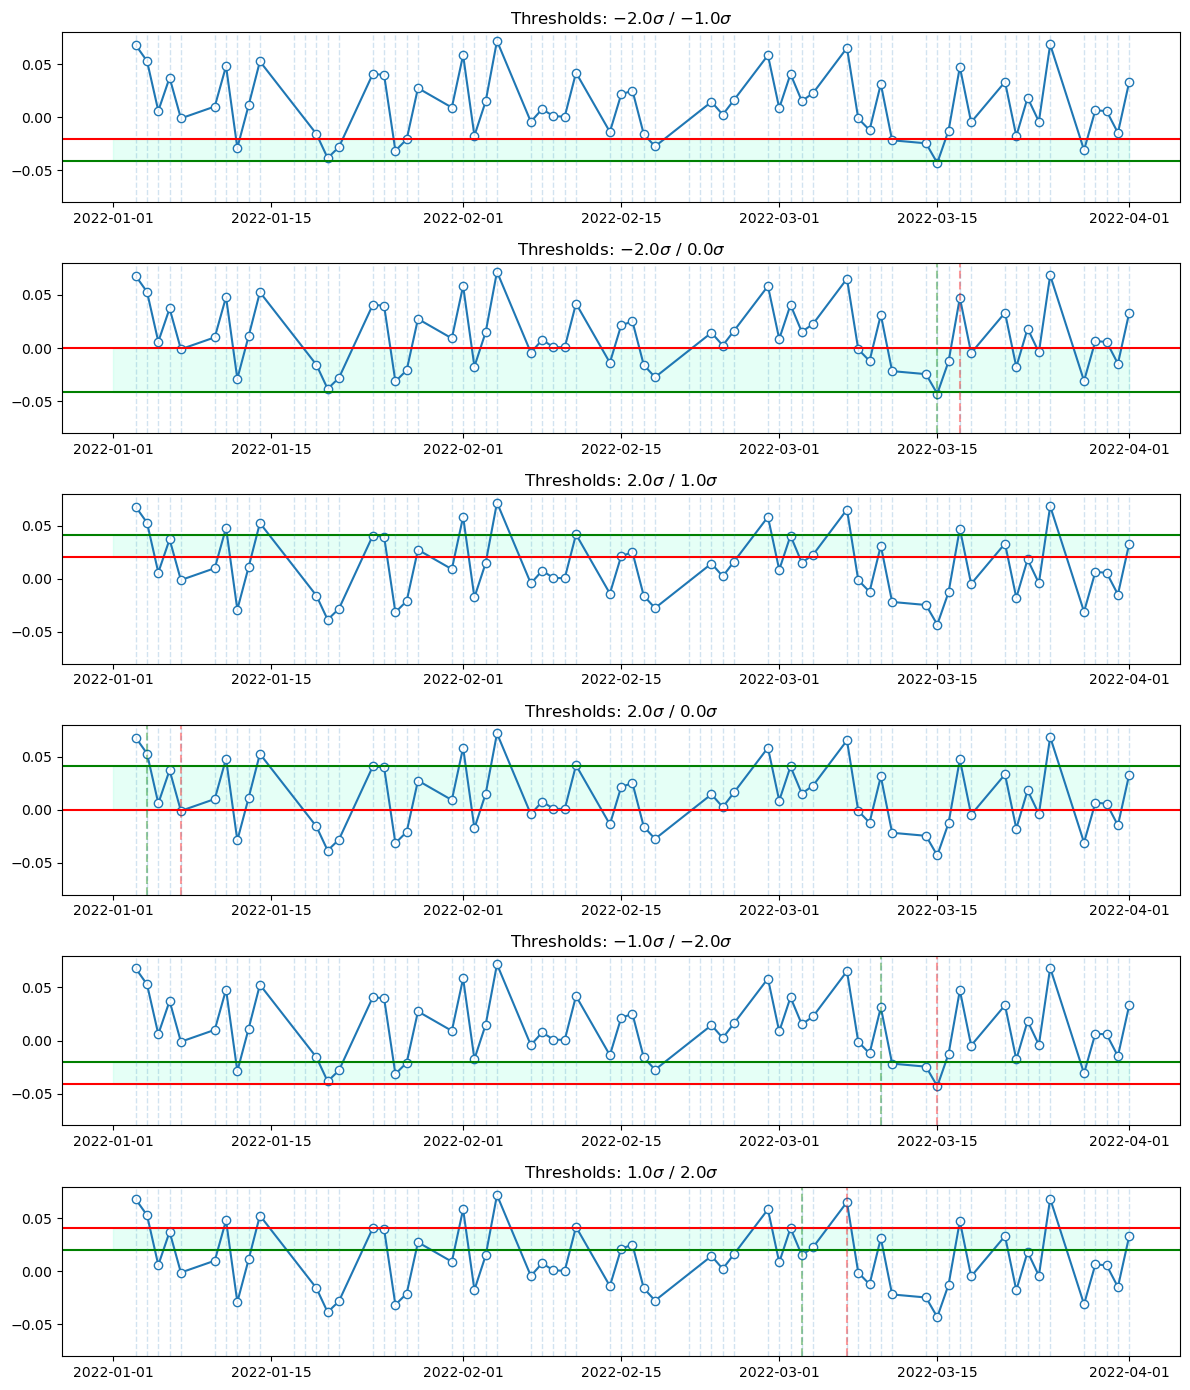

In [24]:
analysts = [a1,a2,a3,a4,a5,a6]
fig, axs = plt.subplots(len(analysts), figsize=(12, 14), layout='tight')
for ax, a in zip(axs, analysts):
    startings, endings = extract_counting_zones(series, a)
    plot_countings(ax, a, startings, endings, yrange=(-0.08, 0.08), xrange=xrange, days=True)

## Rallies and Crashes?
What we define a ''rally'' or a ''crash'' in the returns may not represent an effective increase or decrease in stock price.

In [11]:
prices_df = pd.read_pickle('../data/raw/UN.pickle')
prices_df.loc[slice(*xrange), stocks]

,HP
2022-01-03,25.31
2022-01-04,26.65
2022-01-05,26.81
2022-01-06,27.81
2022-01-07,27.78
...,...
2022-03-28,42.89
2022-03-29,43.17
2022-03-30,43.42
2022-03-31,42.78


Rally


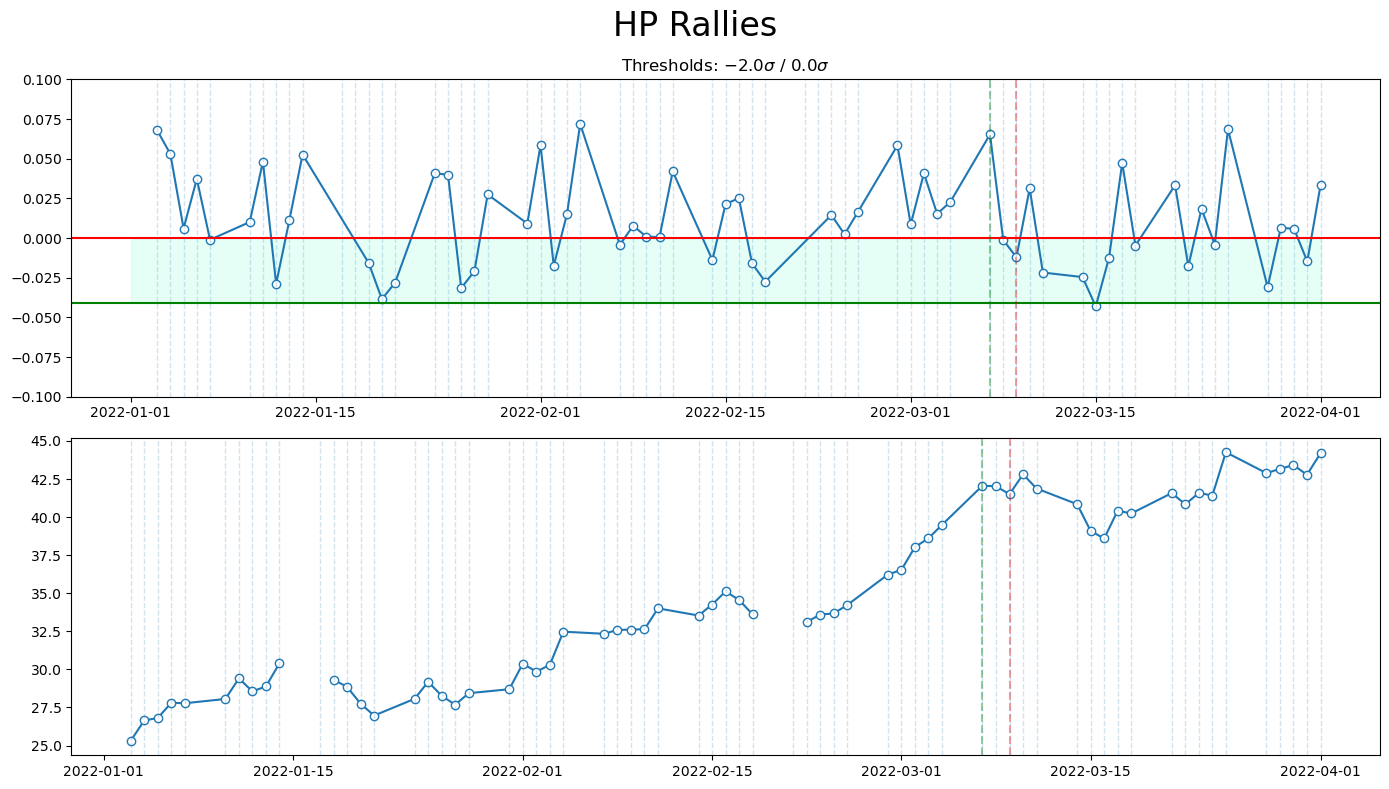

In [17]:
series = df.loc[slice(*xrange), LOOK_STOCK].squeeze()

def plot_countings_in_price(name, series, analyst, xrange):
    filename = '../data/raw/UN.pickle'
    fig, axs = plt.subplots(2, figsize=(14, 8), layout='tight')
    fig.suptitle(f"{name[0]} Rallies", fontsize=24)
    startings, endings = extract_counting_zones(series, analyst)
    plot_countings(axs[0], analyst, startings, endings, xrange=xrange, days=True)
    # Load prices
    df = pd.read_pickle(filename).loc[slice(*xrange), stocks]
    axs[1].plot(df.index, df.values, marker='o', mfc='w')
    for i in range(len(startings)):
        axs[1].axvline(startings[i], 0, 1, ls='--', color='green', alpha=0.4)
        axs[1].axvline(endings[i], 0, 1, ls='--', color='red', alpha=0.4)
    # for ax in axs:
    #     ax.axvline(pd.Timestamp('2022-01-17'), 0, 1, c='b')  # Martin Luther King Jr. Day 
    #     ax.axvline(pd.Timestamp('2022-01-18'), 0, 1, c='b')
    for d in pd.date_range(*xrange):
        if d in series.index:
            axs[1].axvline(d, 0, 1, ls='--', lw=1, alpha=0.2)

plot_countings_in_price(stocks, series, a2, xrange)

## Do we count NaN values?

In this case ('NVR' stock), from 2022-01-10 to 2022-01-19 we removed the 15th and 16th (Saturday and Sunday), but also the 17th was Martin Luther King say and there was no trading, so 2022-01-17 and 2022-01-18 are also ignored in the counting

In [13]:
pd.concat([series.loc['2022-01-10':'2022-01-19'], prices_df.loc['2022-01-10':'2022-01-19', stocks]], axis=1)

,HP,HP
2022-01-10,0.010079,28.06
2022-01-11,0.048111,29.41
2022-01-12,-0.028902,28.56
2022-01-13,0.011204,28.88
2022-01-14,0.052632,30.40
2022-01-17,NaN,NaN
2022-01-18,NaN,29.32
2022-01-19,-0.015689,28.86


In [14]:
args = (
    a1.threshold_start,
    a1.threshold_end,
    a1.divergence_limit,
    a1.tau_min,
    a1.tau_max,
)
fht = count_stock_fht(series, *args, squeeze=True).reshape(4, -1)
pd.DataFrame(fht).T

Rally
2022-01-03 00:00:00: 0.04111755115022238 - -0.06793248945147679 - 0.02055877557511119
2022-01-04 00:00:00: 0.04111755115022238 - -0.05294350059265107 - 0.02055877557511119
2022-01-05 00:00:00: 0.04111755115022238 - -0.006003752345215663 - 0.02055877557511119
2022-01-06 00:00:00: 0.04111755115022238 - -0.03729951510630358 - 0.02055877557511119
2022-01-07 00:00:00: 0.04111755115022238 - 0.0010787486515640987 - 0.02055877557511119
2022-01-10 00:00:00: 0.04111755115022238 - -0.010079193664506825 - 0.02055877557511119
2022-01-11 00:00:00: 0.04111755115022238 - -0.04811119030648614 - 0.02055877557511119
2022-01-12 00:00:00: 0.04111755115022238 - 0.028901734104046284 - 0.02055877557511119
2022-01-13 00:00:00: 0.04111755115022238 - -0.011204481792717047 - 0.02055877557511119
2022-01-14 00:00:00: 0.04111755115022238 - -0.05263157894736836 - 0.02055877557511119
2022-01-19 00:00:00: 0.04111755115022238 - 0.01568894952251021 - 0.02055877557511119
2022-01-20 00:00:00: 0.04111755115022238 - 0.

,0,1,2,3
